(20, 10000, 64, 64)
(64, 64)
(20, 10000, 4096)


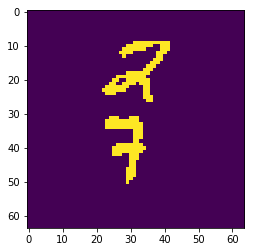

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import sys

%matplotlib inline
data = np.load('/home/stud/wangc/lab/mnist_test_seq.npy')
print(data.shape)
print(data[0,0].shape)
data = np.around(data/255,decimal=5)
plt.imshow(data[0,0,:,:])
data = data.reshape(data.shape[0],data.shape[1],-1)
print(data.shape)

In [ ]:
hidden_num = 2000
maxtime = 20
batch_size = 50
frame_size = 64
desired = frame_size*frame_size

graph = tf.Graph()
with graph.as_default():
    enc_inputs = tf.placeholder(tf.float32, shape = [maxtime, batch_size, desired], name='enc_inputs')

    with tf.variable_scope('encode', reuse=None):
        enc_cell = tf.contrib.rnn.LSTMCell(hidden_num)
        _, enc_state = tf.nn.dynamic_rnn(enc_cell, enc_inputs, dtype=tf.float32, time_major=True)
        print('enc_state %r' % (enc_state,))


    saved_output = tf.Variable(tf.zeros([batch_size, hidden_num]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, hidden_num]), trainable=False)

    # projection weights and biases.
    w = tf.Variable(tf.truncated_normal([hidden_num, desired], -0.1, 0.1, dtype=tf.float32), name='w')
    b = tf.Variable(tf.zeros([desired]),name='b', dtype=tf.float32)

    outputs = list()
    output = saved_output
    state = saved_state
    dec_inputs = tf.zeros([batch_size, desired])
    dec_state = enc_state

    with tf.variable_scope('dec_scope',reuse=None):
        dec_cell = tf.contrib.rnn.LSTMCell(hidden_num)
        v = None
        for _ in range(maxtime):
            with tf.variable_scope('unrolling', reuse=v):
                output, dec_state = dec_cell(dec_inputs, dec_state)
                if v == None:
                    print('output shape %r' % (output.shape,))
                v = True
                outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                    saved_state.assign(state)]):
        print('before stack shape %r' % (outputs[0].shape))       
        outputs = [tf.matmul(i, w) + b for i in outputs]
        outputs = tf.stack(outputs)
        print('projected shape %r' % (outputs.shape,))
        reversed_outputs = outputs[::-1]
        print('reversed shape %r' % (reversed_outputs.shape,))
        loss = tf.reduce_mean(tf.squared_difference(reversed_outputs,enc_inputs))
    # Optimizer.
    global_step = tf.Variable(0, trainable = False)
    learning_rate = tf.train.exponential_decay(
            0.1, global_step, 12000, 0.9, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(
            zip(gradients, v), global_step=global_step)
    saver = tf.train.Saver()
    #create summary for loss
    tf.summary.scalar('loss', loss)
    #tf.summary.tensor_summary('gradients', gradients)
    #tf.summary.tensor_summary('projection_weights', w)
    summary_op = tf.summary.merge_all()
train_size = 9000
epoch = 10000
steps = int(train_size/batch_size)
#summary_frequency = 5


restore = False
with tf.Session(graph=graph) as session:
    if restore==False:
        tf.global_variables_initializer().run()
        writer = tf.summary.FileWriter('logdir', graph)
        print('Initialized')
        for _ in range(epoch):
            for i in range(steps):
                _,l,_,summary = session.run([optimizer, loss, learning_rate, summary_op], feed_dict={enc_inputs:(data[:,i*batch_size:(i+1)*batch_size])})
                writer.add_summary(summary, epoch*steps+i)
        saver.save(session,"./model.ckpt")
        writer.close()
    else:
        saver.restore(session, "./model.ckpt")
        print("model restored")
        val_outputs, l, wo, bo = session.run([outputs, loss, w, b], feed_dict={enc_inputs:data[:,0:batch_size]})
        print('outputs shape %r' % (val_outputs.shape,))
        print("validate error %f" % l)
        for j in range(2):
            tmp_in = data[j*(-1)-1,0]
            plt.figure()
            plt.imshow(tmp_in.reshape(64,-1))
            tmp_out = val_outputs[j,0,:]
            plt.figure()
            plt.imshow(tmp_out.reshape(64,-1))
        test_outputs, test_l, _, _ = session.run([outputs, loss, w, b], feed_dict={enc_inputs:data[:,9000:9000+batch_size]})
        print("test error %f" % test_l)
        for j in range(2):
            tmp_in = data[j*(-1)-1,9000]
            plt.figure()
            plt.imshow(tmp_in.reshape(64,-1))
            tmp_out = test_outputs[j,0,:]
            plt.figure()
            plt.imshow(tmp_out.reshape(64,-1))
    print('finished')

enc_state LSTMStateTuple(c=<tf.Tensor 'encode/rnn/while/Exit_2:0' shape=(?, 2000) dtype=float32>, h=<tf.Tensor 'encode/rnn/while/Exit_3:0' shape=(?, 2000) dtype=float32>)
output shape TensorShape([Dimension(50), Dimension(2000)])
before stack shape TensorShape([Dimension(50), Dimension(2000)])
projected shape TensorShape([Dimension(20), Dimension(50), Dimension(4096)])
reversed shape TensorShape([Dimension(20), Dimension(50), Dimension(4096)])
Initialized


In [ ]:
%%javascript
Jupyter.notebook.session.delete();